In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_validate, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import joblib

from src.config import (
    MASTER_DF_FILE,
    RANDOM_SEED,
    MODELS_DIR,
    MUNICIPALITY_COLUMN,
    WEATHER_COLUMNS,
    SERVICES_COLUMNS,
    AGE_COLUMNS,
    INCOME_COLUMN,
    POP_DENSITY_COLUMN,
    URBAN_CLUSTER_FILE,
    CLUSTER_LABELS
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
df_master = pd.read_csv(URBAN_CLUSTER_FILE)
target_column = "log_price_sqm"

numerical_features = WEATHER_COLUMNS + SERVICES_COLUMNS + [INCOME_COLUMN, POP_DENSITY_COLUMN]
categorical_features = AGE_COLUMNS + ["cluster_urban"]
feature_cols = numerical_features + categorical_features

cluster_counts = df_master['cluster_urban'].value_counts().sort_index()
print(cluster_counts)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", "passthrough", categorical_features),
    ],
    remainder="drop",
)

cluster_urban
0    3003
1     238
2      17
3      17
4     652
5      34
Name: count, dtype: int64


In [ ]:
selected_clusters = [0, 1, 4]
for cluster_id in selected_clusters:
    label = CLUSTER_LABELS["cluster_urban"].get(cluster_id, f"Cluster {cluster_id}")
    print(f"  Cluster {cluster_id}: {label}")


  Cluster 0: Rural
  Cluster 1: Suburbs
  Cluster 4: Urban


In [19]:
model_configs = {
    "elasticnet": {"class": ElasticNet, "params": {"alpha": 0.1, "l1_ratio": 0.5, "random_state": RANDOM_SEED, "max_iter": 5000}},
    "gbm": {"class": GradientBoostingRegressor, "params": {"n_estimators": 100, "max_depth": 5, "learning_rate": 0.1, "random_state": RANDOM_SEED, "subsample": 0.8, "max_features": "sqrt"}},
}

In [22]:
cluster_results = {}
cluster_pipelines = {}

for cluster_id in selected_clusters:
    cluster_label = CLUSTER_LABELS["cluster_urban"].get(cluster_id, f"Cluster {cluster_id}")
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}: {cluster_label}")
    print(f"{'='*80}")

    df_cluster = df_master[df_master['cluster_urban'] == cluster_id].copy()

    df_train = df_cluster[df_cluster['year'] < 2023].copy()
    df_test = df_cluster[df_cluster['year'] == 2023].copy()
    
    print(f"Training samples (2019-2022): {len(df_train)}")
    print(f"Test samples (2023): {len(df_test)}")
    
    if len(df_train) == 0 or len(df_test) == 0:
        print(f"WARNING: Insufficient data for cluster {cluster_id}, skipping...")
        continue

    X_train = df_train[feature_cols].copy()
    y_train = df_train[target_column].copy()
    groups_train = df_train[MUNICIPALITY_COLUMN].values

    X_test = df_test[feature_cols].copy()
    y_test = df_test[target_column].copy()

    valid_train = X_train.notna().all(axis=1) & y_train.notna()
    X_train = X_train[valid_train].reset_index(drop=True)
    y_train = y_train[valid_train].reset_index(drop=True)
    groups_train = groups_train[valid_train]
    
    valid_test = X_test.notna().all(axis=1) & y_test.notna()
    X_test = X_test[valid_test].reset_index(drop=True)
    y_test = y_test[valid_test].reset_index(drop=True)
    
    print(f"After removing missing values:")
    print(f"  Training: {len(X_train)} samples, {len(np.unique(groups_train))} municipalities")
    print(f"  Test: {len(X_test)} samples")

    cluster_results[cluster_id] = {}
    cluster_pipelines[cluster_id] = {}

    gkf = GroupKFold(n_splits=5)
    scoring = {"r2": "r2", "neg_mse": "neg_mean_squared_error", "neg_mae": "neg_mean_absolute_error"}
    
    for model_key, config in model_configs.items():
        print(f"\n  Training {model_key.upper()}...")
        
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("regressor", config["class"](**config["params"])),
        ])

        cv_scores = cross_validate(
            pipeline, X_train, y_train,
            cv=gkf, groups=groups_train,
            scoring=scoring, return_train_score=True, n_jobs=-1
        )

        pipeline.fit(X_train, y_train)

        y_pred_test = pipeline.predict(X_test)

        test_r2 = r2_score(y_test, y_pred_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_mae = mean_absolute_error(y_test, y_pred_test)

        cluster_results[cluster_id][model_key] = {
            'cv_r2_mean': cv_scores["test_r2"].mean(),
            'cv_r2_std': cv_scores["test_r2"].std(),
            'cv_rmse': np.sqrt(-cv_scores["test_neg_mse"]).mean(),
            'cv_mae': (-cv_scores["test_neg_mae"]).mean(),
            'test_r2': test_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae
        }
        
        cluster_pipelines[cluster_id][model_key] = pipeline
        
        print(f"    CV R² (2019-2022): {cv_scores['test_r2'].mean():.4f} (+/- {cv_scores['test_r2'].std():.4f})")
        print(f"    Test R² (2023): {test_r2:.4f}")
        print(f"    Test RMSE: {test_rmse:.4f}")
        print(f"    Test MAE: {test_mae:.4f}")

print(f"\n{'='*80}")
print("Training complete for all clusters!")


CLUSTER 0: Rural
Training samples (2019-2022): 2307
Test samples (2023): 696
After removing missing values:
  Training: 2307 samples, 176 municipalities
  Test: 696 samples

  Training ELASTICNET...
    CV R² (2019-2022): 0.2482 (+/- 0.2286)
    Test R² (2023): 0.3477
    Test RMSE: 0.4502
    Test MAE: 0.3413

  Training GBM...
    CV R² (2019-2022): 0.4704 (+/- 0.1292)
    Test R² (2023): 0.8320
    Test RMSE: 0.2285
    Test MAE: 0.1780

CLUSTER 1: Suburbs
Training samples (2019-2022): 182
Test samples (2023): 56
After removing missing values:
  Training: 182 samples, 14 municipalities
  Test: 56 samples

  Training ELASTICNET...
    CV R² (2019-2022): 0.4348 (+/- 0.4693)
    Test R² (2023): 0.7268
    Test RMSE: 0.1913
    Test MAE: 0.1623

  Training GBM...
    CV R² (2019-2022): -0.1728 (+/- 0.8424)
    Test R² (2023): 0.7913
    Test RMSE: 0.1672
    Test MAE: 0.1494

CLUSTER 4: Urban
Training samples (2019-2022): 488
Test samples (2023): 164
After removing missing values:
  Tr

In [ ]:
results_summary = []

for cluster_id in selected_clusters:
    if cluster_id not in cluster_results:
        continue
    
    cluster_label = CLUSTER_LABELS["cluster_urban"].get(cluster_id, f"Cluster {cluster_id}")
    
    for model_key in model_configs.keys():
        if model_key not in cluster_results[cluster_id]:
            continue
        
        metrics = cluster_results[cluster_id][model_key]
        
        results_summary.append({
            "Cluster ID": cluster_id,
            "Cluster": cluster_label,
            "Model": model_key,
            "CV R² (2019-2022)": metrics['cv_r2_mean'],
            "CV R² Std": metrics['cv_r2_std'],
            "Test R² (2023)": metrics['test_r2'],
            "CV RMSE": metrics['cv_rmse'],
            "Test RMSE (2023)": metrics['test_rmse'],
            "CV MAE": metrics['cv_mae'],
            "Test MAE (2023)": metrics['test_mae']
        })

results_df = pd.DataFrame(results_summary)

display(results_df.round(4))

MODELS_DIR.mkdir(parents=True, exist_ok=True)
results_path = MODELS_DIR / "temporal_validation_by_cluster.csv"
results_df.to_csv(results_path, index=False)


Temporal Validation Results by Cluster:


,Cluster ID,Cluster,Model,CV R² (2019-2022),CV R² Std,Test R² (2023),CV RMSE,Test RMSE (2023),CV MAE,Test MAE (2023)
0,0,Rural,elasticnet,0.2482,0.2286,0.3477,0.4210,0.4502,0.3195,0.3413
1,0,Rural,gbm,0.4704,0.1292,0.8320,0.3553,0.2285,0.2725,0.1780
2,1,Suburbs,elasticnet,0.4348,0.4693,0.7268,0.1896,0.1913,0.1711,0.1623
3,1,Suburbs,gbm,-0.1728,0.8424,0.7913,0.2731,0.1672,0.2239,0.1494
4,4,Urban,elasticnet,0.1383,0.3792,0.3985,0.3331,0.3401,0.2613,0.2879
5,4,Urban,gbm,-0.0678,0.4096,0.8240,0.3701,0.1840,0.2843,0.1429



Results saved to C:\Users\gdmarques\Documents\FCD-housing-prices\models\temporal_validation_by_cluster.csv


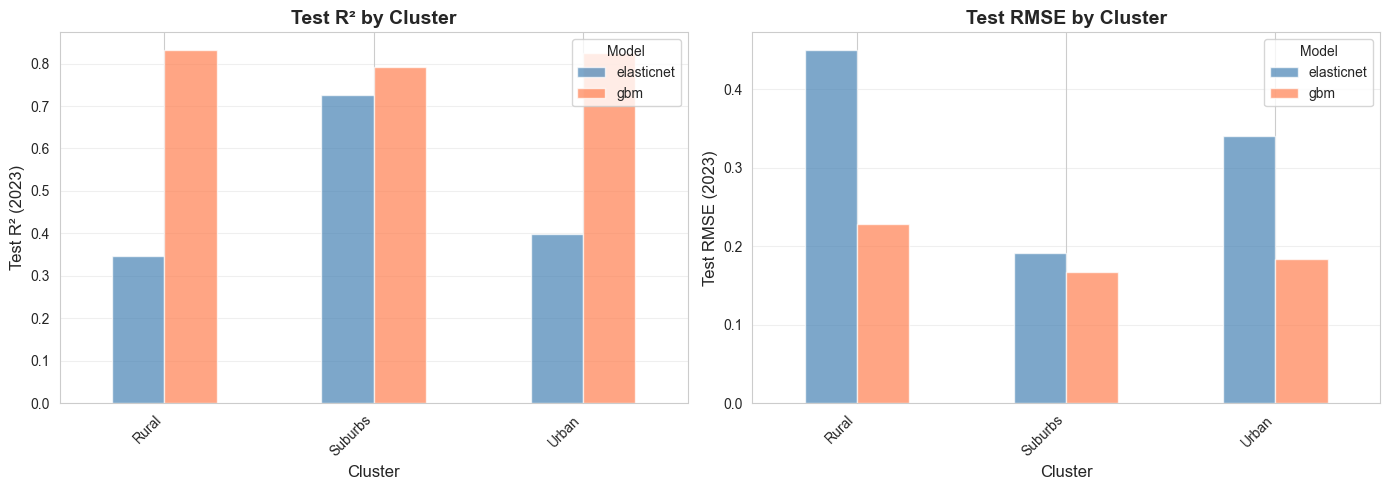

: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

test_r2_data = results_df.pivot(index='Cluster', columns='Model', values='Test R² (2023)')
test_r2_data.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'], alpha=0.7)
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Test R² (2023)', fontsize=12)
axes[0].set_title('Test R² by Cluster', fontsize=14, fontweight='bold')
axes[0].legend(title='Model', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

test_rmse_data = results_df.pivot(index='Cluster', columns='Model', values='Test RMSE (2023)')
test_rmse_data.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'], alpha=0.7)
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Test RMSE (2023)', fontsize=12)
axes[1].set_title('Test RMSE by Cluster', fontsize=14, fontweight='bold')
axes[1].legend(title='Model', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()